In [151]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Prior analysis

In [152]:
%%writefile home/lab3_prior.stan
generated quantities {
    int<lower=0> N = 50;
    real<lower=0, upper=1> p = beta_rng(2, 8);
    int<lower=0, upper=N> y = binomial_rng(N, p);
}

Overwriting home/lab3_prior.stan


In [153]:
gen_quant = CmdStanModel(stan_file='home/lab3_prior.stan')

INFO:cmdstanpy:compiling stan file /home/lab3_prior.stan to exe file /home/lab3_prior


INFO:cmdstanpy:compiled model executable: /home/lab3_prior


In [154]:
samples = gen_quant.sample(data={'N': 50}, fixed_param=True, iter_warmup = 1, iter_sampling=1000, chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [155]:
samples.draws_pd()

,lp__,accept_stat__,N,p,y
0,0.0,0.0,50.0,0.110107,3.0
1,0.0,0.0,50.0,0.288379,14.0
2,0.0,0.0,50.0,0.113714,6.0
3,0.0,0.0,50.0,0.044701,6.0
4,0.0,0.0,50.0,0.164142,12.0
...,...,...,...,...,...
995,0.0,0.0,50.0,0.350359,18.0
996,0.0,0.0,50.0,0.034507,5.0
997,0.0,0.0,50.0,0.152114,5.0
998,0.0,0.0,50.0,0.030089,2.0


In [156]:
prior_ratio = samples.stan_variable('y') / samples.stan_variable('N')

In [157]:
prior_ratio_mean = prior_ratio.mean()
print(f"Predicted prior ratio of allergic reactions: {prior_ratio_mean}")

Predicted prior ratio of allergic reactions: 0.20398000000000002


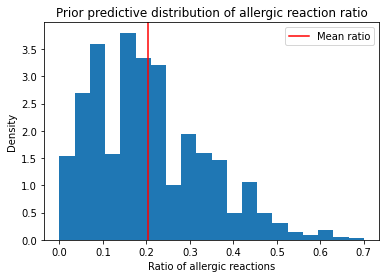

In [158]:
plt.hist(prior_ratio, bins=20, density=True)
plt.axvline(x=prior_ratio_mean, ymin=0, ymax = 4, color='r', label='Mean ratio')
plt.xlabel("Ratio of allergic reactions")
plt.ylabel("Density")
plt.title("Prior predictive distribution of allergic reaction ratio")
plt.legend()
plt.show()


## Posterior analysis

In [159]:
%%writefile home/lab3_posterior.stan

data {
    int<lower=0> N;
    int<lower=0, upper=N> y;
}

parameters {
    real<lower=0, upper=1> p;
}

model {
    p ~ beta(2, 8);
    y ~ binomial(N, p);
}

generated quantities {
    int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}

Overwriting home/lab3_posterior.stan


In [160]:
gen_quant = CmdStanModel(stan_file='home/lab3_posterior.stan')

INFO:cmdstanpy:compiling stan file /home/lab3_posterior.stan to exe file /home/lab3_posterior


In [ ]:
samples = gen_quant.sample(data={'N': 50, 'y': 7}, fixed_param=False, iter_sampling=1000, chains = 1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
samples.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-25.3854,0.973434,1.08019,2.0,3.0,0.0,25.5130,0.140327,3.0
1,-25.4196,0.986064,1.08019,1.0,3.0,0.0,25.4789,0.166009,9.0
2,-26.1993,0.831413,1.08019,1.0,3.0,0.0,26.2058,0.215845,8.0
3,-26.9383,0.553894,1.08019,2.0,3.0,0.0,29.4498,0.080810,5.0
4,-25.5048,0.938875,1.08019,2.0,3.0,0.0,27.6178,0.175672,9.0
...,...,...,...,...,...,...,...,...,...
995,-25.3692,0.958745,1.08019,2.0,3.0,0.0,25.8754,0.155389,7.0
996,-25.5184,0.956375,1.08019,1.0,3.0,0.0,25.5910,0.125492,7.0
997,-26.0858,0.913871,1.08019,1.0,3.0,0.0,26.0914,0.100327,3.0
998,-25.8664,1.000000,1.08019,1.0,1.0,0.0,26.1038,0.107732,5.0


In [ ]:
posterior_ratio = samples.stan_variable('y_pred') / 50

In [ ]:
posterior_ratio_mean = posterior_ratio.mean()
print(f"Predicted posterior ratio of allergic reactions: {posterior_ratio_mean}")

Predicted posterior ratio of allergic reactions: 0.14864000000000005


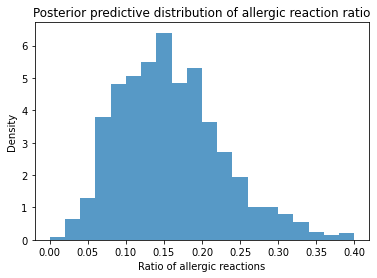

In [ ]:
plt.hist(posterior_ratio, bins=20, density=True, alpha=0.75)
plt.xlabel("Ratio of allergic reactions")
plt.ylabel("Density")
plt.title("Posterior predictive distribution of allergic reaction ratio")
plt.show()

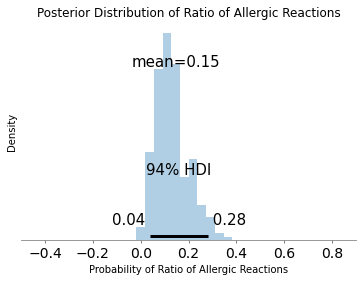

In [ ]:
az.plot_posterior(posterior_ratio, kind='hist', hdi_prob=0.94, point_estimate='mean') #HDI - Highest Density Interval
plt.title("Posterior Distribution of Ratio of Allergic Reactions")
plt.xlabel("Probability of Ratio of Allergic Reactions")
plt.ylabel("Density")
plt.show()

In [ ]:
az_summary = az.summary(samples, var_names=['p', 'y_pred'], kind='stats', hdi_prob=0.94)
az_summary

,mean,sd,hdi_3%,hdi_97%
p,0.149,0.044,0.072,0.23
y_pred,7.432,3.425,2.000,14.00


In [ ]:
p_mean = az_summary.loc['p', 'mean']
print(f"Mean value of parameter p in the posterior distribution: {p_mean}")

Mean value of parameter p in the posterior distribution: 0.149


The mean value of parameter p = 0.149 suggesting that the average probability of allergic  reaction is around 15%.

In [ ]:
p_hdi_lower, p_hdi_upper = az_summary.loc['p', 'hdi_3%'], az_summary.loc['p', 'hdi_97%']
print(f"Highest density interval for posterior probability for the parameter p:\nlower bound: {p_hdi_lower}\nupper bound: {p_hdi_upper}")

Highest density interval for posterior probability for the parameter p:
lower bound: 0.072
upper bound: 0.23


These boundaries means that the probability of allergic  reaction falls within the range from 0.072 to 0.23

In [ ]:
probability_lower_than_average = np.mean(posterior_ratio < 0.2)
print(f"Probability that ratio is lower than average: {probability_lower_than_average}")

Probability that ratio is lower than average: 0.755
